# Spooky Author Identification

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

Problem : Mulilabel text classification into different classes i.e. EAP HPL MWS

Evaluation Metric : Multiclass Log loss

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
train = pd.read_csv(r'C:\Users\Sabeeha\Desktop\project\spooky\train.csv',index_col='id')
test = pd.read_csv(r'C:\Users\Sabeeha\Desktop\project\spooky\test.csv',index_col='id')
submission = pd.read_csv(r'C:\Users\Sabeeha\Desktop\project\spooky\sample_submission.csv')
#df = pd.concat([train,test], axis=0,ignore_index=True)

In [4]:
train.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# anlyse submission file to understand what is required
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [6]:
test.head()

,text
id,
id02310,"Still, as I urged our leaving Ireland with suc..."
id24541,"If a fire wanted fanning, it could readily be ..."
id00134,And when they had broken down the frail door t...
id27757,While I was thinking how I should possibly man...
id04081,I am not sure to what limit his knowledge may ...


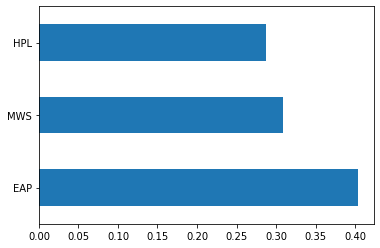

In [7]:
# Target variable analysis
train['author'].value_counts(normalize=True).plot(kind='barh')

In [ ]:
# examine the text characters length in test_df and record these
test['text_length'] = test['text'].str.len()

In [8]:
# lable encoding for for target variable
d = {'EAP':0, 'HPL':1, 'MWS':2}
train['author'] = train['author'].map(d)

## Text preprocessing

In [9]:
import nltk
from nltk.stem.snowball import SnowballStemmer

# Identify the stemmer we'll be using to normalize our training data
stemmer = SnowballStemmer("english")

#stop_words = nltk.corpus.stopwords.words('english'))

In [10]:
# Pre-process our transcripts by removing numbers, punctuation, and stopwords and then stemming the remaining text

# remove digits
train['text'] = train['text'].apply(lambda s: re.sub(r'\d+', '', s))

# remove punctuation
#train['text'] = train['text'].apply(lambda s: re.sub('[' + string.punctuation + ']', '', s))

# lowering and removing punctuation
train['text'] = train['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))

# perform stemming
#train['text'] = train['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))

In [11]:
# train , test , split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train['text'], 
                                                      train['author'], 
                                                      stratify=train['author'], 
                                                      random_state=42, 
                                                      test_size=0.1, 
                                                      shuffle=True)

X_train.shape, X_valid.shape

((17621,), (1958,))

In [12]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

tfv = TfidfVectorizer(min_df=3,
                      max_df=0.95,
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')

tfv.fit(list(X_train) + list(X_valid))
xtrain_tfv  =  tfv.transform(X_train) 
xvalid_tfv  = tfv.transform(X_valid)

### Logistics Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
lr = LogisticRegression()
lr.fit(xtrain_tfv,y_train)
y_pred = lr.predict_proba(xvalid_tfv)
log_loss(y_valid,y_pred)

0.5758583447741286

### MultinomialNB

In [14]:
# Naive Bayes Classification
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(xtrain_tfv,y_train)
y_pred = clf.predict_proba(xvalid_tfv)
log_loss(y_valid,y_pred)

0.5825369372829245

## xgboost

In [16]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv, y_train)
y_pred = clf.predict_proba(xvalid_tfv)
log_loss(y_valid,y_pred)

0.7915089695471357

# SVM after applying TruncatedSVD (LSA)

Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM. Also, note that before applying SVMs, we must standardize the data by scaling.

__Latent Semantic Analysis__

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [ ]:
# step 1 : apply SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=120) #120-200 components are good enough for SVM model
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Variance ratio
print('Components:\n', svd.components_)
print('Explained variance:\n', svd.explained_variance_, '\n')
print('Variance ratio: ',np.cumsum(svd.explained_variance_ratio_)[-1])

In [ ]:
# step 2 : apply scaling on the data obtained from SVD. Renaming variable to reuse without scaling.
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
# setp 3 : Fitting a simple SVM
from sklearn.svm import SVC
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, y_train)
predictions = clf.predict_proba(xvalid_svd_scl)

### Final Submission File

In [ ]:
y_pred = clf.predict_proba(X_test)
df = pd.DataFrame(y_pred,index = test.index,columns= ['MWS','EAP','HPL'])
df.head()

## Topic Modelling.

Topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.

   - Latent Semantic Indexing Model (LSI) using Truncated SVD
   - Latent Dirichlet Allocation (LDA or pLSI)
   - Non-Negative Matrix Factorization Model (NMF)
 
__Assumptions__

- Documents exhibit multiple topics (but typically not many)
- LDA is a probabilistic model with a corresponding generative process
- A topic is a distribution over a fixed vocabulary
- Only the number of topics is specified in advance

        
__Metrics__
 
   - Log likelihood (higher is better)
   - Perplexity (lower is better)
 

__Latent Semantic Analysis (LSI)__

This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the  r= n_topics largest singular values preserved.

__Latent Dirichlet Allocation (proababilistic LSI)__

LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again,just like with LSA).

Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word. LDA learns the relationships between words, topics, and documents by assuming documents are generated by a particular probabilistic model. LDA is a probabilistic model capable of expressing uncertainty about the placement of topics across texts and the assignment of words to topics,

__Non-negative Matrix Factorization (NMF)__ 

Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative. NMF is a deterministic algorithm which arrives at a single representation of the corpus. For this reason, NMF is often characterized as a machine learning algorithm.


__Note__

- Like LDA, NMF arrives at its representation of a corpus in terms of something resembling “latent topics”.
- better results with NMF (over TF-IDF matrix) than with LDA (with TF matrix).

__Multinomial Distribution vs Dirichlet Distribution__

Dirichlet distribution is a distribution over all multinomial distributions of the same dimensionality. If a multinomial distribution is a die, a Dirichlet distribution is a dice factory.

__Gibbs Sampling__

Gibbs sampling is an example of a Markov Chain Monte Carlo (MCMC) technique


## Dimensionality Reduction


__Principal Component Analysis__

an special case of SVD

__SVD__

Full matrix factorization techinique. Singular Value Decomposition decomposes M into three smaller matrices


__truncatedSVD__

TruncatedSVD implements a variant of singular value decomposition (SVD) that only computes the  largest singular values, where  is a user-specified parameter. When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality. SVD and truncateSVD does not differ much, since they are based on the same theory that the eigenvectors with the less eigenvalue are discarded.

__t-Distributed Stochastic Neighbor Embedding (t-SNE)__

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3.

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

__SVD vs NMF__

NMF only takes positive values as input while SVD can take both positive and negative values.

SVD helps in giving Eigen vectors of the input matrix. The technique is used generally where Eigen Vectors are of interest to us. PCA is one classic example.

NMF is another decomposition technique where we try to split the matrix R into the product of two matrices U and V. Our objective here is to get the two matrices U and V, so that their matrix multiplication gives us the matrix R. Here R is typically very very sparse, which is true in a lot of recommender systems. In such cases NMF works better as the missing-values assumption is inbuilt to the algo.

In case of SVD, it doesn’t assume anything about mis?sing values. So you need to give some missing value imputation for SVD. This might bring in unnecessary noise. But if your ratings matrix is not too sparse, SVD might produce better results. SVD results are more deterministic compared to that of NMF. That also can play a role in which method you choose.
 
 

In [15]:
# LDA is a probabilistic topic modeling approach while NMF is matrix factorization approach
# Topic modelling is an unsupervised text mining approach

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_features = 1000
no_topics = 20

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model (pLSA)
tf_vectorizer = CountVectorizer(max_df=0.95,min_df=2,max_features=no_features,stop_words='english')
tf = tf_vectorizer.fit_transform(X_train)
tf_feature_names = tf_vectorizer.get_feature_names()

In [16]:
# NMF
nmf = NMF(n_components=no_topics,random_state=1,alpha=.1,l1_ratio=.5,init='nndsvd')
nmf.fit(tfidf)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=20, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [17]:
# LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [18]:
# define hleper function to Display Topics
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print ("Topic:",idx, " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [36]:
# for NMF
display_topics(nmf, tfidf_feature_names, 10)

Topic: 0 eyes old house left heard far place men felt room
Topic: 1 said dupin let friend dear yes sir sure thousand altogether
Topic: 2 did appear come return believe perdita feel understand wish mr
Topic: 3 man old young dead animal business god sat excellent small
Topic: 4 time spent space short mean passed high year occupied reached
Topic: 5 heart love soul hope affection dear words joy child nature
Topic: 6 saw looked light moon went form face felt feet waves
Topic: 7 little difficulty truth way age gave degree trouble car means
Topic: 8 say mean truth course general dont strange dare just possible
Topic: 9 great measure god difficulty length took degree distance suffered stone
Topic: 10 like looked old ye light sleep face water look earth
Topic: 11 thought heard felt unknown knew really possible mind moment soul
Topic: 12 know dont tell matter certain think right just gone fact
Topic: 13 things strange sea earth knew says told speak state world
Topic: 14 thing wonder terrible wor

In [20]:
# for LDA
display_topics(lda, tf_feature_names, 10)

Topic: 0 seen away looked body hope turned thousand entered change dream
Topic: 1 did good course street sea object large times true dear
Topic: 2 half air appeared horror scene morning second terrible countenance memory
Topic: 3 men world hand friend young wild thoughts vast merely arms
Topic: 4 soul moon called nearly attention remained led child age green
Topic: 5 eyes things room knew strange think mind known near present
Topic: 6 long came length spirit hours person brought continued poor time
Topic: 7 man come soon dark city water father power passed taken
Topic: 8 said time door earth longer reason work west read family
Topic: 9 shall house moment end feel white suddenly dreams speak country
Topic: 10 old know words years went matter truth believe knowledge houses
Topic: 11 night like let deep feet mr general fell home floor
Topic: 12 life thought head open small lay tears eyes joy ground
Topic: 13 light black right people ancient hands means grew window appearance
Topic: 14 hea

In [21]:
 #Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_)
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = ["Topic" + str(i) for i in range(lda.n_components)] # term weights

In [23]:
df_topic_keywords.head(5)

,able,absence,absolutely,accident,account,act,action,actually,added,admiration,...,world,write,written,ye,year,years,yellow,yes,young,youth
Topic0,68.555695,0.050002,0.050008,0.050001,0.050018,0.050001,0.050001,51.186990,0.050002,0.050001,...,0.050197,0.050001,0.050002,0.050003,88.305796,0.050009,0.050002,0.050003,0.050003,0.050002
Topic1,0.050001,0.050002,0.050005,0.050001,0.050002,0.050004,0.050001,0.050006,0.050001,0.050002,...,0.050001,0.050001,0.050001,0.050001,0.050002,0.050002,0.050001,0.050001,0.050002,0.050002
Topic2,0.050001,0.050004,0.050002,0.050001,0.050001,0.050005,42.082574,0.050003,0.050001,0.050002,...,0.050002,0.050001,0.050001,0.050001,0.050001,0.050002,0.050001,0.050002,0.050002,0.050001
Topic3,0.050001,62.980701,0.050001,0.050001,0.050006,0.050001,0.050001,0.050001,0.050001,0.050003,...,283.117823,0.050001,0.050002,0.050002,0.050001,0.050002,0.050006,0.050003,206.698440,0.050003
Topic4,0.050001,0.050001,0.050003,0.050001,0.050003,0.050005,0.050001,0.050011,0.050001,0.050002,...,0.050001,0.050001,0.050002,0.050001,0.050001,52.554394,0.050003,0.050001,0.050002,0.050003


## Visualizing LDA with pyLDAvis

__Saliency:__ a measure of how much the term tells you about the topic.

__Relevance:__ a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

The size of the bubble measures the importance of the topics, relative to the data.

In [34]:
import pyLDAvis.sklearn
vis_data=pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(vis_data)

## Topic model evaluation
You can evaluate LDA models using Coherence measurement, and visualize the final result using PyLDAvis. A set of statements or facts is said to be coherent, if they support each other.

The most common way to evaluate a probabilistic model is to measure the log-likelihood of a held-out test set.

In [31]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tfidf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tfidf))

# See model parameters
print(lda.get_params())

Log Likelihood:  -335395.6175410904
Perplexity:  9826.661252001102
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
